In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support
import time
import pickle

In [2]:
tracks = pd.read_csv("./data/cleaned_data_mil.csv")

In [3]:
track_data = tracks.copy()

encoder = LabelEncoder()
track_data['genre'] = encoder.fit_transform(track_data['genre'])

features = track_data[['popularity', 'duration_ms', 'danceability', 'energy', 'key', 'loudness', 'mode', 
                       'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 
                       'time_signature']]
target = track_data['genre']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=15)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

with open('./data/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
with open('./data/encoder.pkl', 'wb') as f:
    pickle.dump(encoder, f)

In [4]:
n_neighbors_list = [20, 40, 60, 80, 100]

results = {
    'n_neighbors': [],
    'accuracy': [],
    'precision_micro': [],
    'recall_micro': [],
    'f1_micro': [],
    'precision_macro': [],
    'recall_macro': [],
    'f1_macro': [],
    'time': []
}

best_accuracy = 0
best_model = None
best_n_neighbors = 0

kf = StratifiedKFold(n_splits=5)

for n in n_neighbors_list:
    accuracy_scores = []
    precision_micro_scores = []
    recall_micro_scores = []
    f1_micro_scores = []
    precision_macro_scores = []
    recall_macro_scores = []
    f1_macro_scores = []
    time_taken = []
    knn = None

    for train_index, val_index in kf.split(X_train_scaled, y_train):
        X_train_kf, X_val_kf = X_train_scaled[train_index], X_train_scaled[val_index]
        y_train_kf, y_val_kf = y_train.iloc[train_index], y_train.iloc[val_index]
        
        start_time = time.time()
        knn = KNeighborsClassifier(n_neighbors=n)
        knn.fit(X_train_kf, y_train_kf)
        y_pred_kf = knn.predict(X_val_kf)
        end_time = time.time()
        
        accuracy_scores.append(accuracy_score(y_val_kf, y_pred_kf))
        precision_micro, recall_micro, f1_micro, _ = precision_recall_fscore_support(y_val_kf, y_pred_kf, average='micro')
        precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(y_val_kf, y_pred_kf, average='macro')
        
        precision_micro_scores.append(precision_micro)
        recall_micro_scores.append(recall_micro)
        f1_micro_scores.append(f1_micro)
        precision_macro_scores.append(precision_macro)
        recall_macro_scores.append(recall_macro)
        f1_macro_scores.append(f1_macro)
        time_taken.append(end_time - start_time)

    results['n_neighbors'].append(n)
    results['accuracy'].append(np.mean(accuracy_scores))
    results['precision_micro'].append(np.mean(precision_micro_scores))
    results['recall_micro'].append(np.mean(recall_micro_scores))
    results['f1_micro'].append(np.mean(f1_micro_scores))
    results['precision_macro'].append(np.mean(precision_macro_scores))
    results['recall_macro'].append(np.mean(recall_macro_scores))
    results['f1_macro'].append(np.mean(f1_macro_scores))
    results['time'].append(np.mean(time_taken))

    if np.mean(accuracy_scores) > best_accuracy:
        best_accuracy = np.mean(accuracy_scores)
        best_model = knn
        best_n_neighbors = n

Best n_neighbors: 60
Best accuracy: 0.5354946472928503
              precision    recall  f1-score   support

    alt-rock       0.35      0.30      0.32      4245
   classical       0.78      0.79      0.79      3531
     country       0.35      0.43      0.39      3565
         edm       0.69      0.63      0.66      9022
     hip-hop       0.56      0.60      0.58      3194
        jazz       0.55      0.45      0.49      3210
         pop       0.42      0.45      0.43      6678
   punk-rock       0.51      0.62      0.56     10174
        rock       0.61      0.45      0.52      6629

    accuracy                           0.54     50248
   macro avg       0.53      0.52      0.53     50248
weighted avg       0.54      0.54      0.54     50248

   n_neighbors  accuracy  precision_micro  recall_micro  f1_micro  \
0           20  0.529942         0.529942      0.529942  0.529942   
1           40  0.535261         0.535261      0.535261  0.535261   
2           60  0.535495         

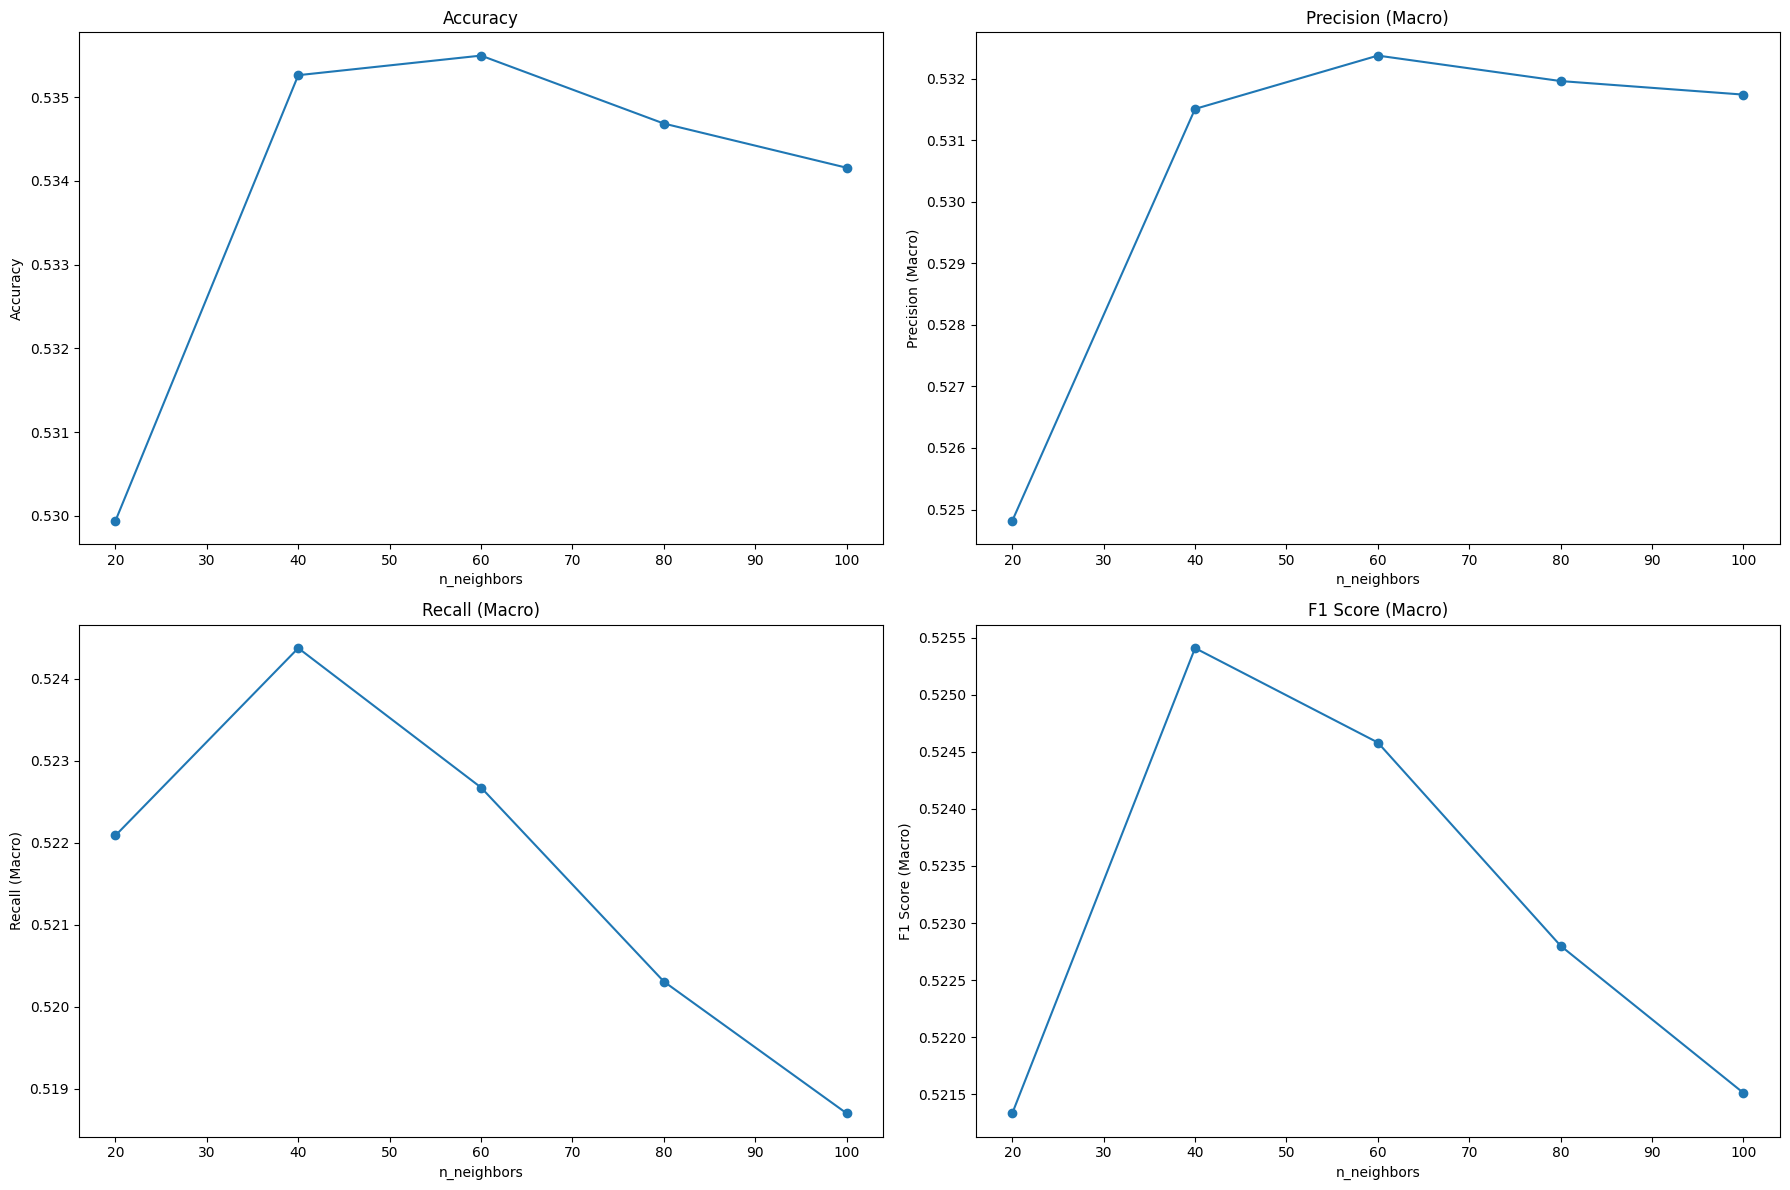

In [16]:
print(f"Best n_neighbors: {best_n_neighbors}")
print(f"Best accuracy: {best_accuracy}")

y_pred = best_model.predict(X_test_scaled)
print(classification_report(y_test, y_pred, target_names=encoder.classes_))

results_df = pd.DataFrame(results)
print(results_df)

fig, axs = plt.subplots(2, 2, figsize=(18, 12))

axs[0, 0].plot(results['n_neighbors'], results['accuracy'], marker='o')
axs[0, 0].set_title('Accuracy')
axs[0, 0].set_xlabel('n_neighbors')
axs[0, 0].set_ylabel('Accuracy')

axs[0, 1].plot(results['n_neighbors'], results['precision_macro'], marker='o')
axs[0, 1].set_title('Precision (Macro)')
axs[0, 1].set_xlabel('n_neighbors')
axs[0, 1].set_ylabel('Precision (Macro)')

axs[1, 0].plot(results['n_neighbors'], results['recall_macro'], marker='o')
axs[1, 0].set_title('Recall (Macro)')
axs[1, 0].set_xlabel('n_neighbors')
axs[1, 0].set_ylabel('Recall (Macro)')

axs[1, 1].plot(results['n_neighbors'], results['f1_macro'], marker='o')
axs[1, 1].set_title('F1 Score (Macro)')
axs[1, 1].set_xlabel('n_neighbors')
axs[1, 1].set_ylabel('F1 Score (Macro)')

plt.tight_layout()
plt.show()

## DO NOT RUN THIS!!!

In [15]:
with open('./data/best_knn_model_mil.pkl', 'wb') as f:
    pickle.dump(best_model, f)

results_df.to_csv('./result/KNN_Model_Evaluation_Results.txt', sep='\t', index=False)

def save_plot(y_values, title, ylabel, filename):
    plt.figure()
    plt.plot(results['n_neighbors'], y_values, marker='o')
    plt.title(title)
    plt.xlabel('n_neighbors')
    
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.savefig(f'./result/{filename}')
    plt.close()

save_plot(results['accuracy'], 'Accuracy', 'Accuracy', 'KNN_Accuracy.png')
save_plot(results['precision_micro'], 'Precision (Micro)', 'Precision (Micro)', 'KNN_Precision_Micro.png')
save_plot(results['recall_micro'], 'Recall (Micro)', 'Recall (Micro)', 'KNN_Recall_Micro.png')
save_plot(results['f1_micro'], 'F1 Score (Micro)', 'F1 Score (Micro)', 'KNN_F1_Micro.png')
save_plot(results['precision_macro'], 'Precision (Macro)', 'Precision (Macro)', 'KNN_Precision_Macro.png')
save_plot(results['recall_macro'], 'Recall (Macro)', 'Recall (Macro)', 'KNN_Recall_Macro.png')
save_plot(results['f1_macro'], 'F1 Score (Macro)', 'F1 Score (Macro)', 'KNN_F1_Macro.png')
save_plot(results['time'], 'Time', 'Time (s)', 'KNN_Time.png')

## Model Evaluation

#### Evaluation Metrics

|                | Predicted Positive | Predicted Negative |
|:--------------:|:------------------:|:------------------:|
| Actual Positive| True Positive (TP) | False Negative (FN)|
| Actual Negative| False Positive (FP)| True Negative (TN) |

For multi-class classification, this concept extends to multiple classes, but the fundamental principles remain the same.

#### Accuracy
- **Definition**: The proportion of correctly classified instances out of the total instances.
- **Formula**: $ \text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN} $
- **Interpretation**: It gives an overall effectiveness of the model, but can be misleading if the data is imbalanced.

#### Precision
- **Definition**: The proportion of true positive predictions among all positive predictions.
- **Formula**: $ \text{Precision} = \frac{TP}{TP + FP} $
- **Interpretation**: High precision indicates a low false positive rate.

#### Recall (Sensitivity)
- **Definition**: The proportion of true positive predictions among all actual positives.
- **Formula**: $ \text{Recall} = \frac{TP}{TP + FN} $
- **Interpretation**: High recall indicates a low false negative rate.

#### F1 Score
- **Definition**: The harmonic mean of precision and recall.
- **Formula**: $ F1 = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}} $
- **Interpretation**: It balances precision and recall, useful when you need to account for both false positives and false negatives.

#### Micro vs. Macro Averaging
- **Micro-Averaging**: Aggregates the contributions of all classes to compute the average metric. It is calculated globally by counting the total true positives, false negatives, and false positives.
  - **Formula**:
  $$ \text{Accuracy}_\text{micro} = \frac{\sum_i TP_i + TN_i}{\text{num of datapoints}} $$
- **Macro-Averaging**: Computes the metric independently for each class and then takes the average. This treats all classes equally, regardless of their size.
  - **Formula**:
  $$ \text{Accuracy}_\text{macro} = \frac{\sum_i \text{Accuracy}_{\text{class}_i}}{\text{num of classes}} $$

### Model Evaluation Based on Results

The evaluation of the KNN model with different values of `n_neighbors` is based on accuracy, precision, recall, and F1 scores. Here are the results:

| n_neighbors | accuracy | precision_micro | recall_micro | f1_micro | precision_macro | recall_macro | f1_macro | time_taken |
|-------------|----------|-----------------|--------------|----------|-----------------|--------------|----------|------------|
| 20          | 0.5301   | 0.5301          | 0.5301       | 0.5301   | 0.5266          | 0.5240       | 0.5233   | 160.06     |
| 50          | 0.5335   | 0.5335          | 0.5335       | 0.5335   | 0.5315          | 0.5235       | 0.5249   | 186.72     |
| 60          | 0.5340   | 0.5340          | 0.5340       | 0.5340   | 0.5323          | 0.5231       | 0.5250   | 200.10     |
| 70          | 0.5335   | 0.5335          | 0.5335       | 0.5335   | 0.5316          | 0.5218       | 0.5237   | 207.17     |
| 100         | 0.5333   | 0.5333          | 0.5333       | 0.5333   | 0.5319          | 0.5197       | 0.5224   | 216.07     |

### Analysis

1. **Accuracy**:
   - The accuracy varies from 0.5301 (k=20) to 0.5340 (k=60). This small range of variation (approximately 0.004) suggests that the model's performance is relatively stable across different values of `n_neighbors`.

2. **Precision (Micro)**:
   - The micro-averaged precision follows the same trend as accuracy, ranging from 0.5301 to 0.5340. This indicates consistent performance in identifying true positives among predicted positives.

3. **Recall (Micro)**:
   - The micro-averaged recall also follows the same trend as accuracy, reflecting the model's ability to correctly identify actual positives.

4. **F1 Score (Micro)**:
   - The micro-averaged F1 score mirrors the precision and recall values, balancing the trade-off between precision and recall.

5. **Precision (Macro)**:
   - The macro-averaged precision ranges from 0.5266 (k=20) to 0.5323 (k=60). This suggests that the model's precision across different classes is relatively consistent.

6. **Recall (Macro)**:
   - The macro-averaged recall ranges from 0.5197 (k=100) to 0.5240 (k=20). This indicates that the model's recall across different classes does not vary significantly.

7. **F1 Score (Macro)**:
   - The macro-averaged F1 score ranges from 0.5224 (k=100) to 0.5250 (k=60), reflecting a balanced performance across different classes.

8. **Time Taken**:
   - The time taken ranges from 160.06 seconds (k=20) to 216.07 seconds (k=100). This indicates that as the value of `n_neighbors` increases, the computation time also increases.

### Conclusion

The evaluation shows that the KNN model's performance is relatively stable across different values of `n_neighbors`. The differences in accuracy, precision, recall, and F1 score are minimal, with the highest performance metrics observed at `n_neighbors = 60`. However, the computation time increases as the value of `n_neighbors` increases. Given these results, one might prioritize other factors such as computational efficiency or simplicity when choosing the optimal `n_neighbors`. 

Overall, the KNN model demonstrates consistent performance, indicating its robustness for this multi-class classification task.

In [4]:
with open('knn_model.pkl', 'rb') as f:
    knn_loaded = pickle.load(f)

/Users/shuzonaruse/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator KNeighborsClassifier from version 1.4.2 when using version 1.5.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


## Present Multiple Genre

In [9]:
import numpy as np

In [10]:
def predict_top_t(knn, X, t=3, n_neighbors=best_n_neighbors):
    neighbors = knn.kneighbors(X, n_neighbors=n_neighbors, return_distance=False)

    top_k_predictions = []
    for neighbor in neighbors:
        neighbor_labels = y_train.iloc[neighbor]
        top_k = neighbor_labels.value_counts().head(t).index.tolist()
        top_k_predictions.append(top_k)
    
    # print("Top k predictions: ", top_k_predictions)

    return top_k_predictions

In [11]:
N = len(np.unique(y_train)) # 9
print("N: ", N)

N:  9


Top 2 Accuracy: 0.7363278140423499, Weighted Accuracy: 0.5896052215116817
Top 3 Accuracy: 0.8378442923101417, Weighted Accuracy: 0.6003416688257548
Top 4 Accuracy: 0.9022647667568858, Weighted Accuracy: 0.5785144736158424
Top 5 Accuracy: 0.9449132303773284, Weighted Accuracy: 0.54214719822905
Top 6 Accuracy: 0.9712426365228467, Weighted Accuracy: 0.4986525963251789
Top 7 Accuracy: 0.9846760070052539, Weighted Accuracy: 0.4523855859267947
Top 8 Accuracy: 0.9899299474605955, Weighted Accuracy: 0.4069723681421851


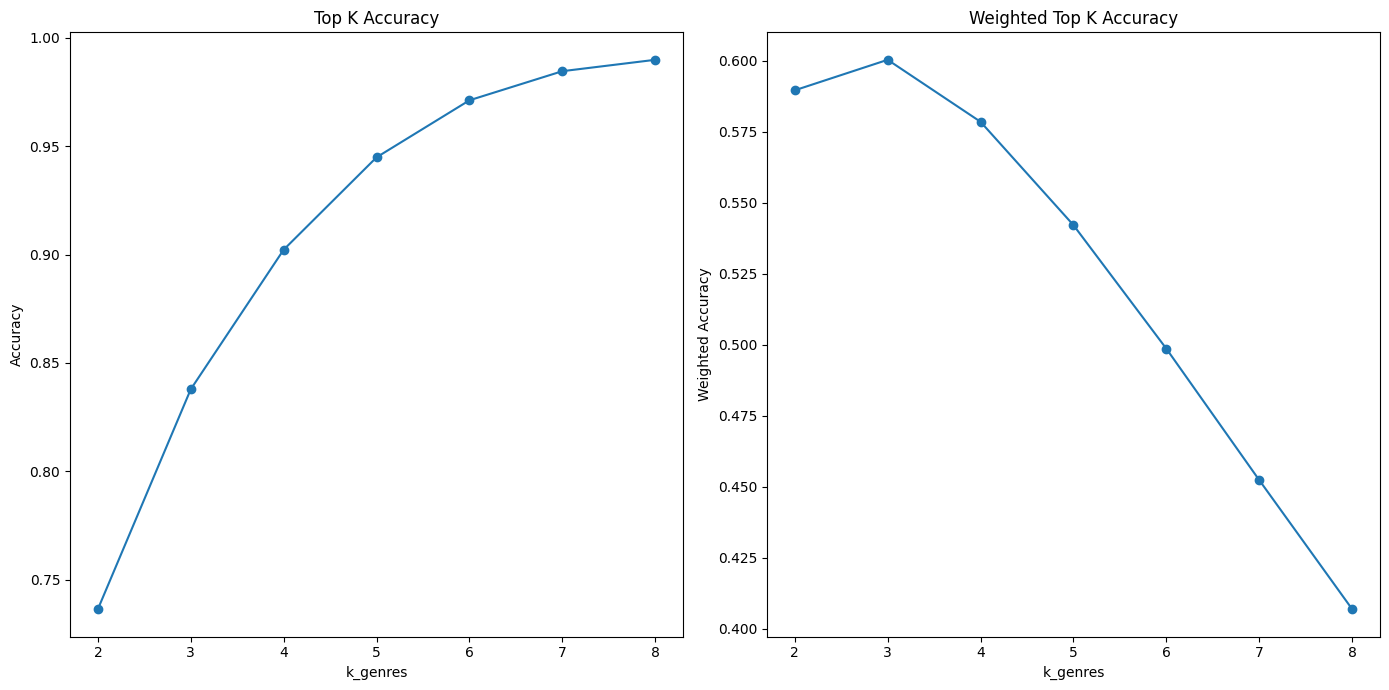

In [12]:
t_list = range(2, N)
accuracy_top_t_list = []
weighted_accuracy_list = []

for t in t_list:
    top_t_predictions = predict_top_t(best_model, X_test_scaled, t=t)

    correct_count = 0
    for i, top_t in enumerate(top_t_predictions):
        if y_test.iloc[i] in top_t:
            correct_count += 1
    accuracy_top_t = correct_count / len(y_test)
    accuracy_top_t_list.append(accuracy_top_t)

    weighted_accuracy = accuracy_top_t * np.exp(-t / N)
    weighted_accuracy_list.append(weighted_accuracy)

    print(f"Top {t} Accuracy: {accuracy_top_t}, Weighted Accuracy: {weighted_accuracy}")

plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.plot(t_list, accuracy_top_t_list, marker='o')
plt.title('Top K Accuracy')
plt.xlabel('k_genres')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(t_list, weighted_accuracy_list, marker='o')
plt.title('Weighted Top K Accuracy')
plt.xlabel('k_genres')
plt.ylabel('Weighted Accuracy')

plt.tight_layout()
plt.show()

In [13]:
results_bf = pd.DataFrame({
    'k_genres': t_list,
    'accuracy_top_k': accuracy_top_t_list,
    'weighted_accuracy': weighted_accuracy_list
})

results_bf.to_csv('./result/KNN_Top_k.txt', sep='\t', index=False)

plt.figure()
plt.plot(t_list, accuracy_top_t_list, marker='o')
plt.title('Top K Accuracy')
plt.xlabel('k_genres')
plt.ylabel('Accuracy')
plt.savefig('./result/KNN_Top_k_Accuracy.png')
plt.close()

plt.figure()
plt.plot(t_list, weighted_accuracy_list, marker='o')
plt.title('Weighted Top K Accuracy')
plt.xlabel('k_genres')
plt.ylabel('Weighted Accuracy')
plt.savefig('./result/KNN_Weighted_Top_k_Accuracy.png')
plt.close()